In [1]:
import json
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt

# register converters for plotting
pd.plotting.register_matplotlib_converters()
plt.style.use('satyam')

# Home Electricity Data

In [2]:
# Load content as text for parsing
with open('./home-electricity-data.json', 'r') as jsonfile:
    content = jsonfile.read()
    
# Once read, convert to json object
as_dict = json.loads(content)

In [3]:
# Parse as dataframe
data = pd.DataFrame(as_dict.get('readings'))

# Add converters for datatypes
data.start = pd.to_datetime(data.start)
data.end = pd.to_datetime(data.end)

## Visualisation

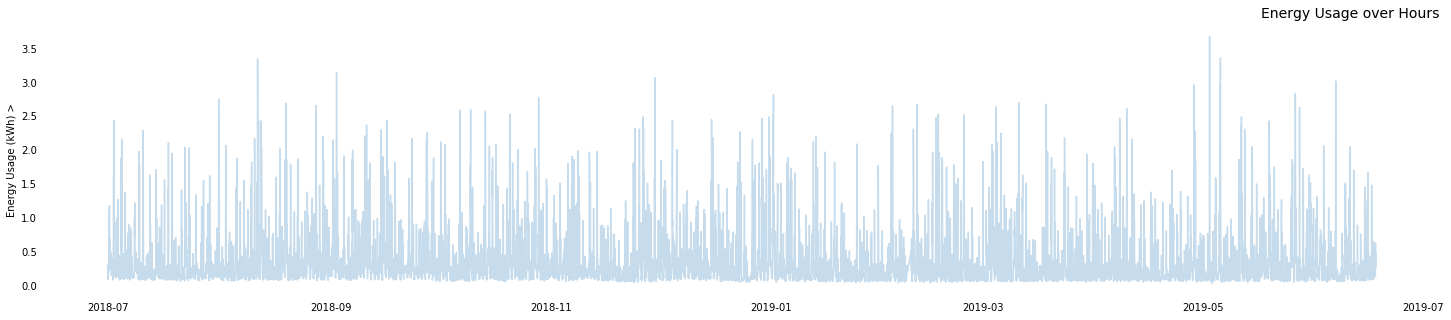

In [4]:
plt.figure(figsize=(25, 5))
plt.title("Energy Usage over Hours", size=14,
          loc="right")
plt.plot(data.start, data.energy_kwh, alpha=0.25)
plt.ylabel("Energy Usage (kWh) >")
plt.show()

In [5]:
# Generate day names for easily splitting the dataset
# into day-name groups for visualisation
data['day_name'] = data.start.apply(lambda x: x.day_name())

# Add integer numbers for the dataset to be easier to 
# split for algorithms
data['day_id'] = data.start.apply(lambda x: x.isoweekday())

# Add time of day counter that converts the timestamps to 
# valid time of day values. This value is used for the plots
data["time_of_day"] = (
    (data.start - data.start.dt.floor('D')) /
    (pd.Timedelta(hours=1)))

With the time of day scatter plots, the basic distribution of values over the day can be seen. This distribution assures that there is a clear correlation between the tenants staying at home and not staying at home. The next goal is to separate these conditions in the dataset using automated methods. Since the data is completely cut using discrete points of measurement in both time and day, the goal is to build a markov model to see whether there will be higher consumption or not.

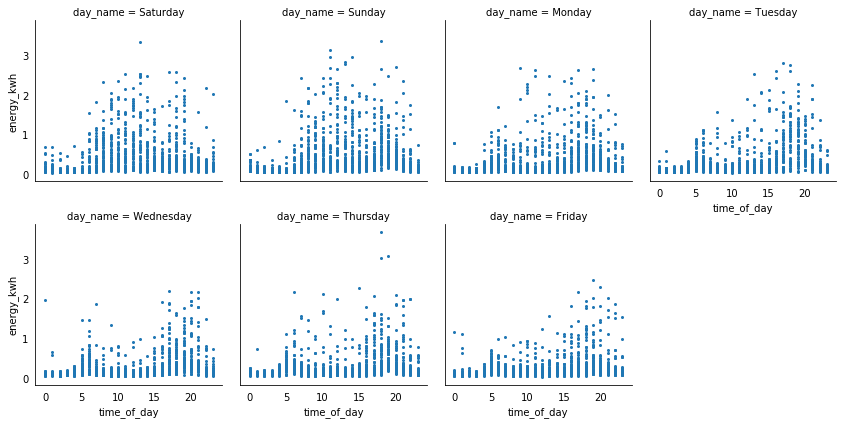

In [6]:
fg = sns.FacetGrid(data=data, col='day_name', col_wrap=4)
fg.map(plt.scatter, 'time_of_day', 'energy_kwh', s=4)
plt.show()

Before we do that, let's see the consumption by time of day across all the days and see how we can split them. However, we know that the data we have is for periods. This means that different sections have different ratios by which they change. That means, that the slower ramp or decrease of such periods is not visible in the dataset.This is seen by a sharp rise starting at 5 and going slowly at 6-8 AM on some days. The other days, it is much slower.

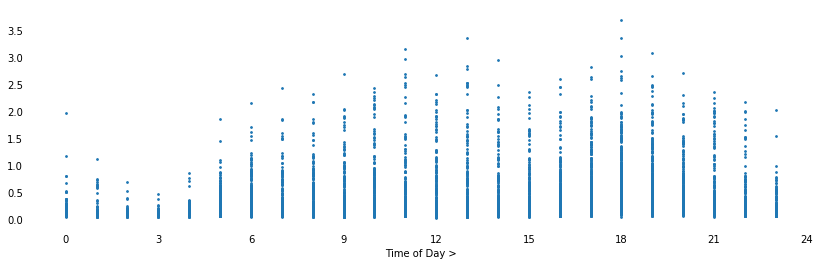

In [7]:
plt.figure(figsize=(14, 4))
plt.scatter(data.time_of_day, data.energy_kwh, s=3)
plt.xlabel("Time of Day >")
plt.xticks(range(0, 25, 3))
plt.show()

The distribution of the energy used can be seen below. On the raw data, it is has a sharp rise of upto 0.5 kWh and then drops rapidly over time. This is because the data includes night time and the empty day time when no one is around the house. This can be separated to create sections in the data. The data is to be separated to three sections: 

1. section (1) Before 0500
2. section (2) between 5 to 21 
3. section (3) After 2100

This separates the three discrete buckets in the dataset. This enables to separate the buckets and visualise them separately within the dataset. That visualisation seen below showsthe distribution along the time buckets. The next dimensional split will be on the day of the week.

In [8]:
data["time_bucket"] = pd.cut(data.time_of_day, bins=[0, 5, 21, 24],
       labels=[1, 2, 3], include_lowest=True, right=True)

/home/vigneshk/Projects/Notebooks/.venv/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


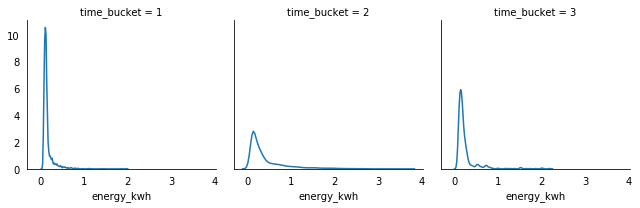

In [9]:
fg = sns.FacetGrid(data=data, col='time_bucket', col_wrap=3)
fg.map(sns.distplot, 'energy_kwh', hist=False)
plt.show()

The major split is the weekend, weekday split. This is done below to illustrate the difference in the weekend and weekday for the energy consumption. The graphs still look identical due to very little variational elements in the dataset. While weekends and weekdays seem to have similar profiles with some variations on the length of the tail.

In [10]:
data['is_weekend'] = data.day_name.isin(["Saturday", "Friday"])

/home/vigneshk/Projects/Notebooks/.venv/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


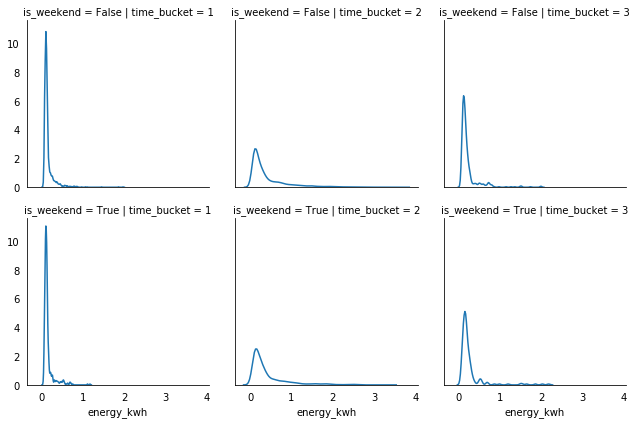

In [11]:
fg = sns.FacetGrid(data=data, col='time_bucket', row='is_weekend')
fg.map(sns.distplot, 'energy_kwh', hist=False)
plt.show()

Right now, it is hard to see whether there is a specific distribution the dataset over time. In order to overcome this specific information loss, the sum of the consumption on each day is taken. This will provide a metric that can be tracked over time. The overall energy use in a day. This will give more support to clustering based on the discrete days of the week. The goal is to see whether there is a strong correlation between energy use over the different weeks of the year  in order to make sure the data does not show uneven spikes. In the daily sum, there are slight changes in the means as the months roll over. This is seen with slight shifts.

In [12]:
energy_by_day = data.groupby(data.start.dt.date).energy_kwh. \
    sum().reset_index()
energy_by_day.start = pd.to_datetime(energy_by_day.start)

# Create date for the start of the month
energy_by_day['month_start'] = energy_by_day.start.astype('datetime64[M]')

# Create steps for the monthly data
energy_by_month = energy_by_day.groupby("month_start").energy_kwh.mean()
energy_by_month_median = energy_by_day.groupby("month_start").energy_kwh.median()

By plotting the mean values, we see that there is a slight decrease in the monthly energy consumption as the new year starts rolling in. The median shows the tendency stronger than the mean. This shows that there was a net decrease at the start of the year with the utilisation of the various electrical appliances at home. This shift also indicates a strong seasonality that is prevalent in the data in addition to weekly and daily cycles.

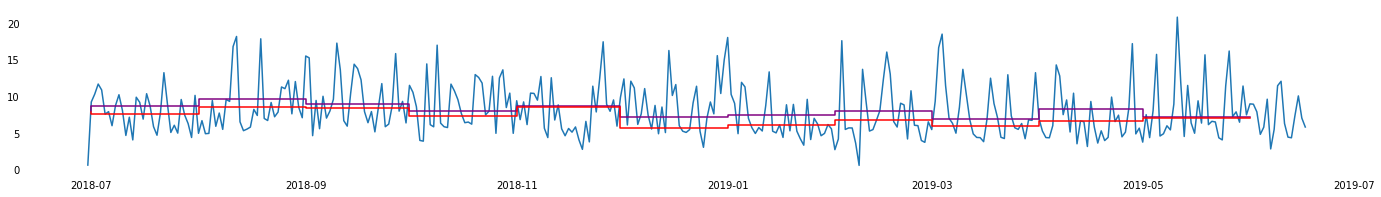

In [13]:
plt.figure(figsize=(24, 3))
plt.plot(energy_by_day.start, energy_by_day.energy_kwh)
plt.step(x=energy_by_month.index[1:], y=energy_by_month.values[1:],
         color="purple")
plt.step(x=energy_by_month.index[1:], y=energy_by_month_median.values[1:],
         color="red")
plt.show()

There is a definite median shift in January as the composition of the house changed. We swapped flatmates out of the home. The below shows the boxplot of the energy consumed across the day while accounting for weekends. Here, the data shows clear signs of occupancy across specific times of the day depending on whether it is a weekend or not a weekend. 

During the weekend, there is a more uniform electricity usage throughout the day. On the weekdays, the electricity use is minimal throughout the day and it increases sharply around 16/17/18 for a higher usage pattern.

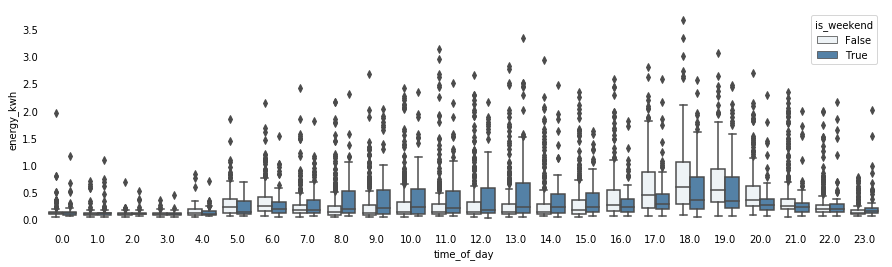

In [14]:
plt.figure(figsize=(15, 4))
sns.boxplot(data=data, x="time_of_day", y="energy_kwh",
              color="steelblue", hue="is_weekend")
plt.show()